## Part 2. Weakly Supervised Learning: Single-Stage Semantic Segmentation from Image Labels
The source code is available at https://github.com/visinf/1-stage-wseg/

## Reminder
![Overview](figures/overview_singlestage.png)

In [1]:
import sys

sys.path.append('1-stage-wseg')

In [2]:
import os
import sys
import numpy as np
import scipy
import torch.multiprocessing as mp
from tqdm import tqdm
from PIL import Image


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
from torch.utils.data import DataLoader
from torch.backends import cudnn
cudnn.enabled = True
cudnn.benchmark = False
cudnn.deterministic = True


In [3]:
from opts import get_arguments
from core.config import cfg, cfg_from_file, cfg_from_list
from models import get_model

from utils.checkpoints import Checkpoint
from utils.timer import Timer
from utils.dcrf import crf_inference
from utils.inference_tools import get_inference_io

In [4]:
import inspect
from IPython.display import Code

In [5]:
from models.stage_net import network_factory, pseudo_gtmask, balanced_mask_loss_ce

In [6]:
# reading the config
cfg_from_file('1-stage-wseg/configs/voc_resnet38.yaml')
cfg['NET']['PRE_WEIGHTS_PATH'] = os.path.join('1-stage-wseg', cfg['NET']['PRE_WEIGHTS_PATH'])


# Loading the model
model = get_model(cfg.NET, num_classes=cfg.TEST.NUM_CLASSES)


Backbone: ResNet38
Model: AE
Loading weights from:  1-stage-wseg/./models/weights/ilsvrc-cls_rna-a1_cls1000_ep-0001.pth


Remember that image-wide prediction is a sum of two terms, nGWP
$$y_c^\text{nGWP} = \frac{\sum_{i,j} m_{c,i,j} y_{c,i,j}}{\epsilon + \sum_{i',j'} m_{c,i',j'}},$$
and focal penalty:
$$y_c^\text{size-focal} = (1-\bar{m}_c)^p \log(\lambda + \bar{m}_c), \:\; \bar{m}_c = \tfrac{1}{hw} \sum_{i,j} m_{c,i,j}.$$

In [7]:
# cls_1 is nGWP output, logits weightred by their softmax value
# cls_2 is focal penalty
# cls is image-wide prediction 
# loss_mask is mask loss calculated from cleaned pseudo-label mask 
Code(inspect.getsource(model.__class__.forward), language='python')

def forward(self, y, y_raw=None, labels=None):
            test_mode = y_raw is None and labels is None

            # 1. backbone pass
            x = self.forward_backbone(y)

            # 2. ASPP modules
            x = self.aspp(x)

            #
            # 3. merging deep and shallow features
            #

            # 3.1 skip connection for deep features
            x2_x = self.fc8_skip(self._backbone['conv3'])
            x_up = rescale_as(x, x2_x)
            x = self.fc8_x(torch.cat([x_up, x2_x], 1))

            # 3.2 deep feature context for shallow features
            x2 = self.shallow_mask(self._backbone['conv3'], x)

            # 3.3 stochastically merging the masks
            x = self.sg(x, x2, alpha_rate=self.cfg.SG_PSI)

            # 4. final convs to get the masks
            x = self.last_conv(x)

            #
            # 5. Finalising the masks and scores
            #

            # constant BG scores
            bg = torch.ones_like(x[:, :1])
            x = torch.cat([bg, x], 1)

            bs, c, h, w = x.size()

            masks = F.softmax(x, dim=1)

            # reshaping
            features = x.view(bs, c, -1)
            masks_ = masks.view(bs, c, -1)

            # classification loss
            cls_1 = (features * masks_).sum(-1) / (1.0 + masks_.sum(-1))

            # focal penalty loss
            cls_2 = focal_loss(masks_.mean(-1), \
                               p=self.cfg.FOCAL_P, \
                               c=self.cfg.FOCAL_LAMBDA)

            # adding the losses together
            cls = cls_1[:, 1:] + cls_2[:, 1:]

            if test_mode:
                # if in test mode, not mask
                # cleaning is performed
                return cls, rescale_as(masks, y)

            self._mask_logits = x

            # foreground stats
            masks_ = masks_[:, 1:]
            cls_fg = (masks_.mean(-1) * labels).sum(-1) / labels.sum(-1)

            # mask refinement with PAMR
            masks_dec = self.run_pamr(y_raw, masks.detach())

            # upscale the masks & clean
            masks = self._rescale_and_clean(masks, y, labels)
            masks_dec = self._rescale_and_clean(masks_dec, y, labels)

            # create pseudo GT
            pseudo_gt = pseudo_gtmask(masks_dec).detach()
            loss_mask = balanced_mask_loss_ce(self._mask_logits, pseudo_gt, labels)

            return cls, cls_fg, {"cam": masks, "dec": masks_dec}, self._mask_logits, pseudo_gt, loss_mask

PARM is used to refine the masks

In [8]:
Code(inspect.getsource(model.__class__.run_pamr), language='python')
# _aff is object of PAMR class

def run_pamr(self, im, mask):
            im = F.interpolate(im, mask.size()[-2:], mode="bilinear", align_corners=True)
            masks_dec = self._aff(im, mask)
            return masks_dec

Remember that PAMR is defined as
$$m^t_{:,i,j} = \sum_{(l,n) \in \mathcal{N}(i,j)} \alpha_{i,j,l,n} \cdot m^{t-1}_{:,l,n},$$
where $\alpha$ is defined as a kernel over input pixels
$$k(I_{i,j}, I_{l,n}) = -\tfrac{ \lvert I_{i,j} - I_{l,n} \rvert }{\sigma_{i,j}^2}$$

In [9]:
from models.mods.pamr import PAMR
Code(inspect.getsource(PAMR), language='python')

class PAMR(nn.Module):

    def __init__(self, num_iter=1, dilations=[1]):
        super(PAMR, self).__init__()

        self.num_iter = num_iter
        self.aff_x = LocalAffinityAbs(dilations)
        self.aff_m = LocalAffinityCopy(dilations)
        self.aff_std = LocalStDev(dilations)

    def forward(self, x, mask):
        mask = F.interpolate(mask, size=x.size()[-2:], mode="bilinear", align_corners=True)

        # x: [BxKxHxW]
        # mask: [BxCxHxW]
        B,K,H,W = x.size()
        _,C,_,_ = mask.size()

        x_std = self.aff_std(x)

        x = -self.aff_x(x) / (1e-8 + 0.1 * x_std)
        x = x.mean(1, keepdim=True)
        x = F.softmax(x, 2)

        for _ in range(self.num_iter):
            m = self.aff_m(mask)  # [BxCxPxHxW]
            mask = (m * x).sum(2)

        # xvals: [BxCxHxW]
        return mask

To generate pseudolabels, we use pseudolabels as ground truth and our prediction as logits:

In [10]:
Code(inspect.getsource(pseudo_gtmask), language='python')

def pseudo_gtmask(mask, cutoff_top=0.6, cutoff_low=0.2, eps=1e-8):
    """Convert continuous mask into binary mask"""
    bs,c,h,w = mask.size()
    mask = mask.view(bs,c,-1)

    # for each class extract the max confidence
    mask_max, _ = mask.max(-1, keepdim=True)
    mask_max[:, :1] *= 0.7
    mask_max[:, 1:] *= cutoff_top
    #mask_max *= cutoff_top

    # if the top score is too low, ignore it
    lowest = torch.Tensor([cutoff_low]).type_as(mask_max)
    mask_max = mask_max.max(lowest)

    pseudo_gt = (mask > mask_max).type_as(mask)

    # remove ambiguous pixels
    ambiguous = (pseudo_gt.sum(1, keepdim=True) > 1).type_as(mask)
    pseudo_gt = (1 - ambiguous) * pseudo_gt

    return pseudo_gt.view(bs,c,h,w)

In [18]:
Code(inspect.getsource(balanced_mask_loss_ce), language='python')

def balanced_mask_loss_ce(mask, pseudo_gt, gt_labels, ignore_index=255):
    """Class-balanced CE loss
    - cancel loss if only one class in pseudo_gt
    - weight loss equally between classes
    """

    mask = F.interpolate(mask, size=pseudo_gt.size()[-2:], mode="bilinear", align_corners=True)
    
    # indices of the max classes
    mask_gt = torch.argmax(pseudo_gt, 1)

    # for each pixel there should be at least one 1
    # otherwise, ignore
    ignore_mask = pseudo_gt.sum(1) < 1.
    mask_gt[ignore_mask] = ignore_index

    # class weight balances the loss w.r.t. number of pixels
    # because we are equally interested in all classes
    bs,c,h,w = pseudo_gt.size()
    num_pixels_per_class = pseudo_gt.view(bs,c,-1).sum(-1)
    num_pixels_total = num_pixels_per_class.sum(-1, keepdim=True)
    class_weight = (num_pixels_total - num_pixels_per_class) / (1 + num_pixels_total)
    class_weight = (pseudo_gt * class_weight[:,:,None,None]).sum(1).view(bs, -1)

    # BCE loss
    loss = F.cross_entropy(mask, mask_gt, ignore_index=ignore_index, reduction="none")
    loss = loss.view(bs, -1)

    # we will have the loss only for batch indices
    # which have all classes in pseudo mask
    gt_num_labels = gt_labels.sum(-1).type_as(loss) + 1 # + BG
    ps_num_labels = (num_pixels_per_class > 0).type_as(loss).sum(-1)
    batch_weight = (gt_num_labels == ps_num_labels).type_as(loss)

    loss = batch_weight * (class_weight * loss).mean(-1)
    return loss

### Results

In [12]:
import requests
import hashlib
import os
 
def verify_sha(filename, sha):
    with open(filename,"rb") as f:
        file_bytes = f.read() 
        file_hash = hashlib.sha256(file_bytes).hexdigest()
    return file_hash == sha

def download_file(url, path):
    os.makedirs(path, exist_ok=True)
    filename = url.split('/')[-1]
    local_filename = os.path.join(path,filename)
    
    with requests.get(url, stream=True, verify=False) as r:
        r.raise_for_status()
        total_size_in_bytes= int(response.headers.get('content-length', 0))
        block_size = 1024 #1 Kibibyte
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(block_size): 
                progress_bar.update(len(chunk))
                f.write(chunk)
        progress_bar.close()
    return local_filename

enc_hash = '100bd5972bd22e1608ddc0b08b30886d4d151a857c7de2ef1d03517498b8c785'
enc_path = "./1-stage-wseg/models/weights/model_enc_e020Xs0.928.pth"
enc_link = "https://download.visinf.tu-darmstadt.de/data/2020-cvpr-araslanov-1-stage-wseg/models/model_enc_e020Xs0.928.pth"
if not os.path.isfile(enc_path) or not verify_sha(enc_path, enc_hash):
    if os.path.isfile(enc_path):
        os.remove(enc_path)
    download_file(enc_link, "./1-stage-wseg/models/weights")

in_path = "./1-stage-wseg/models/weights/ilsvrc-cls_rna-a1_cls1000_ep-0001.pth"
in_hash = 'de5cdaa1db199c7a05b8e5bf53da9534beb753fab88f7960245586fa1ec60537'
in_link = "https://download.visinf.tu-darmstadt.de/data/2020-cvpr-araslanov-1-stage-wseg/models/ilsvrc-cls_rna-a1_cls1000_ep-0001.pth"
if not os.path.isfile(in_path) or not verify_sha(in_path, in_hash):
    if os.path.isfile(in_path):
        os.remove(in_path)
    download_file(in_link, "./1-stage-wseg/models/weights")

In [13]:
def check_dir(base_path, name):

    # create the directory
    fullpath = os.path.join(base_path, name)
    if not os.path.exists(fullpath):
        os.makedirs(fullpath)

    return fullpath

def HWC_to_CHW(img):
    return np.transpose(img, (2, 0, 1))

In [14]:
mask_output_dir = './output'
snapshot_dir = '1-stage-wseg/models/weights'
resume = 'e020Xs0.928'
infer_list = '1-stage-wseg/data/val_voc.txt'
workers = 0

In [15]:
# reading the config
cfg_from_file('1-stage-wseg/configs/voc_resnet38.yaml')

# patch config
cfg['NET']['PRE_WEIGHTS_PATH'] = os.path.join('1-stage-wseg', cfg['NET']['PRE_WEIGHTS_PATH'])
cfg['TEST']['DATA_ROOT'] = os.path.expanduser('~')


# initialising the dirs
check_dir(mask_output_dir, "vis")
check_dir(mask_output_dir, "crf")

# Loading the model
model = get_model(cfg.NET, num_classes=cfg.TEST.NUM_CLASSES)
checkpoint = Checkpoint(snapshot_dir, max_n = 5)
checkpoint.add_model('enc', model)
checkpoint.load(resume)

for p in model.parameters():
    p.requires_grad = False

# setting the evaluation mode
model.eval()

assert hasattr(model, 'normalize')
transform = tf.Compose([np.asarray, model.normalize])

WriterClass, DatasetClass = get_inference_io(cfg.TEST.METHOD)

dataset = DatasetClass(infer_list, cfg.TEST, transform=transform)

dataloader = DataLoader(dataset, shuffle=False, num_workers=workers, \
                        pin_memory=True, batch_size=cfg.TEST.BATCH_SIZE)

model = nn.DataParallel(model).cuda()

timer = Timer()
N = len(dataloader)

palette = dataset.get_palette()
#pool = mp.Pool(processes=workers)
writer = WriterClass(cfg.TEST, palette, mask_output_dir)

for iter, (img_name, img_orig, images_in, pads, labels, gt_mask) in enumerate(tqdm(dataloader)):

    # cutting the masks
    masks = []

    with torch.no_grad():
        cls_raw, masks_pred = model(images_in)

        if not cfg.TEST.USE_GT_LABELS:
            cls_sigmoid = torch.sigmoid(cls_raw)
            cls_sigmoid, _ = cls_sigmoid.max(0)
            #cls_sigmoid = cls_sigmoid.mean(0)
            # threshold class scores
            labels = (cls_sigmoid > cfg.TEST.FP_CUT_SCORE)
        else:
            labels = labels[0]

        # saving the raw npy
        image = dataset.denorm(img_orig[0]).numpy()
        masks_pred = masks_pred.cpu()
        labels = labels.type_as(masks_pred)

        writer.save(img_name[0], image, masks_pred, pads, labels, gt_mask[0])
        #pool.apply_async(writer.save, args=(img_name[0], image, masks_pred, pads, labels, gt_mask[0]))

    timer.update_progress(float(iter + 1) / N)
    if iter % 100 == 0:
        msg = "Finish time: {}".format(timer.str_est_finish())
        tqdm.write(msg)
        sys.stdout.flush()
    break

#pool.close()
#pool.join()

Backbone: ResNet38
Model: AE
Loading weights from:  1-stage-wseg/./models/weights/ilsvrc-cls_rna-a1_cls1000_ep-0001.pth
File not found:  1-stage-wseg/models/weights/opt_enc_e020Xs0.928.pth


  0%|          | 0/1449 [00:00<?, ?it/s]

Inference batch size:  8


  0%|          | 0/1449 [00:11<?, ?it/s]

Finish time: Thu Mar 25 15:29:25 2021


  0%|          | 0/1449 [00:11<?, ?it/s]


In [16]:
images  = [x for x in os.listdir('output') if x.endswith('.png')]
image = images[0]

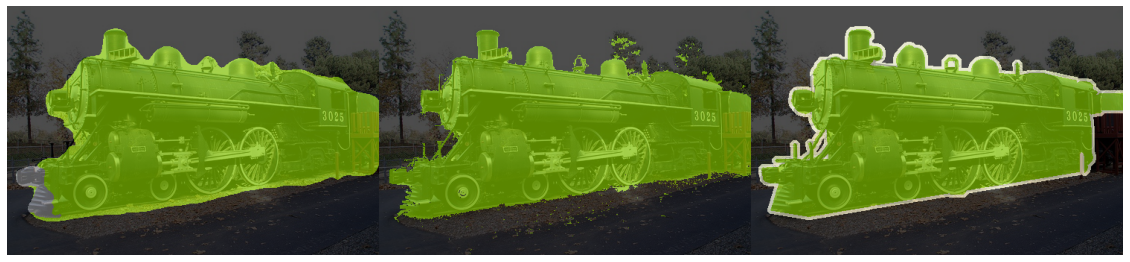

In [17]:
# No CRF, with CRF, GT
fig = plt.figure(figsize=(20,20)) # create a figure with the default size 

ax = fig.add_subplot(1,1,1) 
ax.set_axis_off()

img = mpimg.imread(os.path.join('output','vis',image))
imgplot = plt.imshow(img)
plt.show()